<a href="https://colab.research.google.com/github/fboldt/aulas-am-bsi/blob/main/aula22a_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

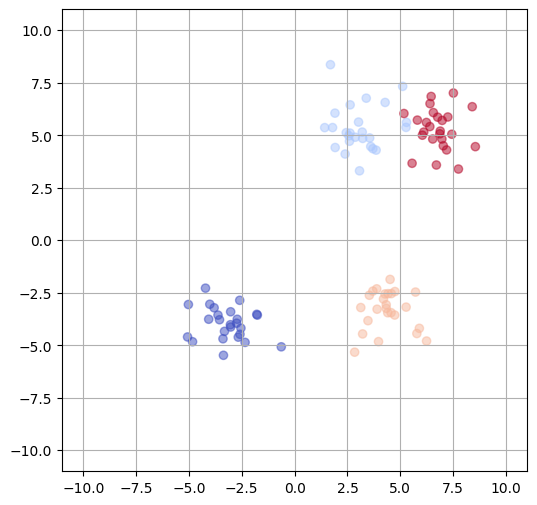

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

n_samples = 100
n_classes = 4

def generate_multiclass_dataset(n_samples, n_classes):
    X, y = make_blobs(n_samples=n_samples,
                      centers=n_classes,
                      n_features = 2,
                      center_box=(-7, 7),
                      cluster_std=1)
    return X, y

def plot_dataset(X, y, xlim=(-11, 11), ylim=(-11, 11)):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, marker='o', alpha=0.5, cmap="coolwarm")
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.grid(True)

def plot_vector(weights):
    xs = [0, weights[0]]
    ys = [0, weights[1]]
    plt.plot(xs, ys, 'g-')

def plot_hyperplane(weights, bias):
    xs = np.array([-11, 11])
    ys = -(weights[0]*xs + bias)/weights[1]
    plt.plot(xs, ys, '--')


X, y = generate_multiclass_dataset(n_samples, n_classes)
plot_dataset(X, y)
plt.show()

In [21]:
y

array([1, 1, 1, 0, 2, 1, 0, 0, 0, 3, 2, 2, 3, 3, 0, 0, 3, 0, 3, 0, 3, 1,
       0, 0, 3, 2, 3, 3, 3, 0, 1, 2, 3, 3, 2, 1, 2, 2, 0, 1, 0, 2, 3, 2,
       3, 0, 1, 1, 2, 1, 0, 1, 1, 3, 1, 0, 2, 2, 3, 1, 2, 2, 2, 0, 1, 0,
       2, 3, 0, 2, 2, 0, 0, 2, 1, 1, 1, 3, 3, 2, 3, 0, 3, 3, 3, 1, 1, 3,
       1, 2, 0, 2, 2, 1, 1, 2, 0, 3, 0, 1])

In [18]:
from abc import ABC, abstractmethod

class CostFunction(ABC):
    @abstractmethod
    def getCost(self, y, ypred):
        pass
    @abstractmethod
    def getGradient(self, X):
        pass

class WidrowHoff(CostFunction):
    def getCost(self, y, ypred):
        self.error = y - ypred
        return 0.5 * np.sum(self.error**2)
    def getGradient(self, X):
        return -X.T @ self.error

In [23]:
from abc import ABC, abstractmethod

class Algorithm(ABC):
    @abstractmethod
    def getW(self, X, y):
        pass


class GradientDescent(Algorithm):
    def __init__(self, max_iter, learning_rate,
                 cost_function=WidrowHoff(),
                 regularization=0):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.cost_function = cost_function
        self.regularization = regularization

    def getW(self, X, y):
        w = np.random.rand(X.shape[1], y.shape[1])
        for _ in range(self.max_iter):
            ypred = X @ w
            cost = self.cost_function.getCost(y, ypred)
            w *= 1 - self.learning_rate * self.regularization
            w -= self.learning_rate * self.cost_function.getGradient(X)
            if cost == 0:
                break
        return w

[[-0.19139181 -0.09979327  0.19295638  0.09675318]
 [-0.02086976  0.15640383 -0.19370061  0.05868604]] [ 0.04858751 -0.35345599 -0.87083368 -0.81518448]
0.97


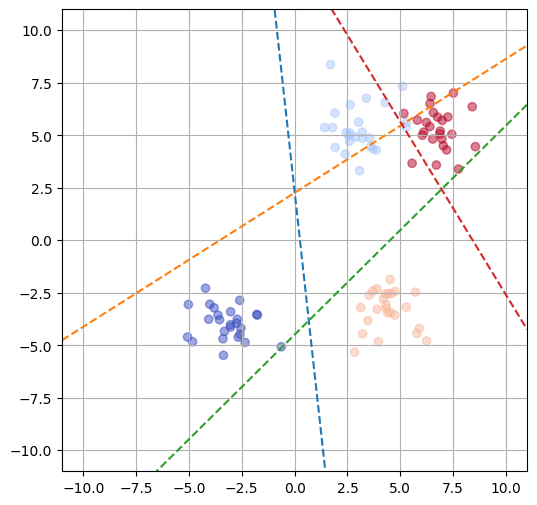

In [47]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer

def include_bias(X):
  ones = np.ones(shape=(X.shape[0],1))
  return np.hstack((ones, X))

class NeuralNetwork(BaseEstimator, ClassifierMixin):
  def __init__(self, algorithm):
    self.algorithm = algorithm

  def fit(self, X, y):
    self.label_binarizer = LabelBinarizer()
    # print(y.shape)
    y = self.label_binarizer.fit_transform(y)
    y = np.where(y == 1, 1, -1)
    # print(y.shape)
    X = include_bias(X)
    self.w = self.algorithm.getW(X, y)
    self.coefs_ = self.w[1:]
    self.intercept_ = self.w[0]
    return self

  def predict(self, X):
    X = include_bias(X)
    ypred = (X @ self.w)
    if self.w.shape[1] == 1:
      return np.sign(ypred)
    return self.label_binarizer.inverse_transform(ypred)


model = NeuralNetwork(algorithm=GradientDescent(1000, 0.0001))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
for i in range(model.w.shape[1]):
  plot_hyperplane(model.coefs_[:, i], model.intercept_[i])
plt.show()

[[-0.38490251 -0.04219574  0.01346194  0.03309765]
 [-0.05059413  0.0584596  -0.01388731  0.00538969]] [ 0.8184921  -0.08063805 -0.06440294 -0.19025869]
0.98


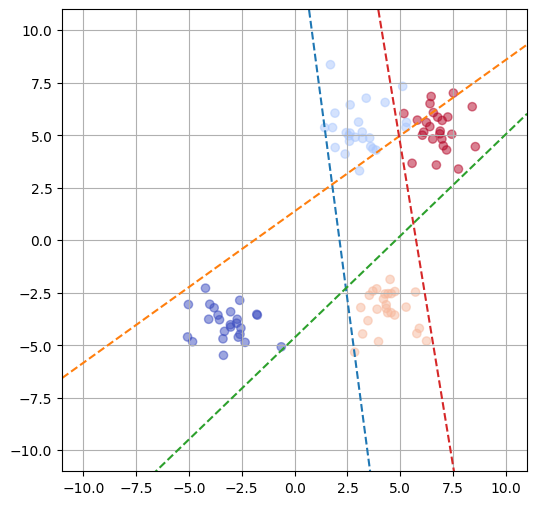

In [64]:
class SmoothedSurrogate(CostFunction):
    def getCost(self, y, ypred):
        self.error = y - np.sign(ypred)
        return np.sum(np.maximum(np.zeros(y.shape), -y * ypred))
    def getGradient(self, X):
        return -X.T @ self.error

model = NeuralNetwork(algorithm=GradientDescent(1000, 0.0001, SmoothedSurrogate()))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
for i in range(model.w.shape[1]):
  plot_hyperplane(model.coefs_[:, i], model.intercept_[i])
plt.show()

[[-0.75936802 -1.03869644  0.64218916  0.76948659]
 [-0.10182027  1.31269939 -0.78174124  0.19788914]] [ 0.61398739 -1.90029884 -3.30144665 -4.87259257]
0.97


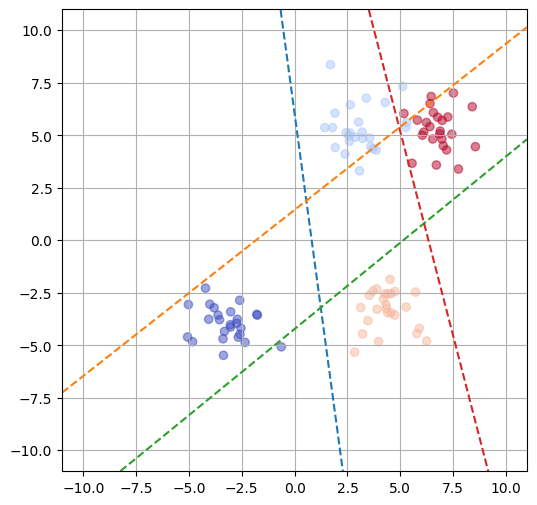

In [71]:
class HingeLoss(CostFunction):
    def getCost(self, y, ypred):
        self.y = y
        self.ypred = ypred
        self.error = y - np.sign(ypred)
        return np.sum(np.maximum(np.zeros(y.shape), 1 - y * ypred))
    def getGradient(self, X):
        marginal_errors = (self.y * self.ypred) < 1
        marginal_ys = np.copy(self.y)
        marginal_ys[~marginal_errors] = 0
        return -X.T @ marginal_ys

model = NeuralNetwork(algorithm=GradientDescent(1000, 0.001, HingeLoss()))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
for i in range(model.w.shape[1]):
  plot_hyperplane(model.coefs_[:, i], model.intercept_[i])
plt.show()

[[-17.846846    -7.09253246  -2.28599077  -1.65874712]
 [ -8.99619718   5.82300916  -4.75148701   2.19284747]] [-3.59119956 -3.88858097 -3.97610257 -3.22387009]
0.9


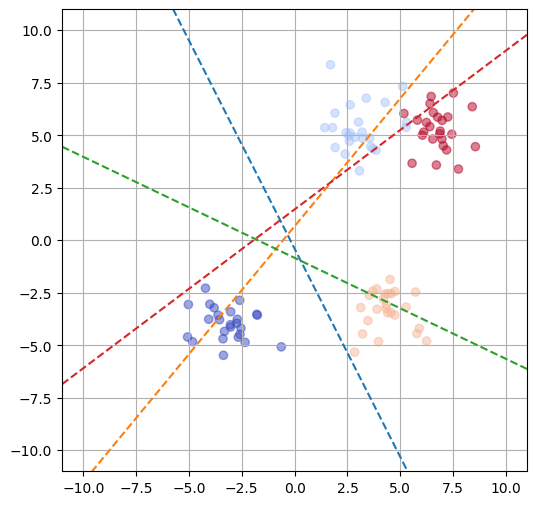

In [83]:
from scipy.special import expit

class LogLikehood(CostFunction):
    def getCost(self, y, ypred):
        self.error = y - expit(ypred)
        return np.sum(np.log(1 + np.exp(-y * ypred)))
    def getGradient(self, X):
        return -X.T @ self.error

model = NeuralNetwork(algorithm=GradientDescent(5000, 0.00001, LogLikehood()))
model.fit(X, y)
print(model.coefs_, model.intercept_)
ypred = model.predict(X)
print(accuracy_score(y, ypred))
plot_dataset(X, y)
for i in range(model.w.shape[1]):
  plot_hyperplane(model.coefs_[:, i], model.intercept_[i])
plt.show()

[[ 0.0863565   0.09372486  0.03238722 -0.21246858]
 [ 0.02464627  0.13434842 -0.18593842  0.02694373]] [-0.58648446 -0.79196487 -0.37391723 -0.24763345]
WidrowHoff 0.8744444444444445


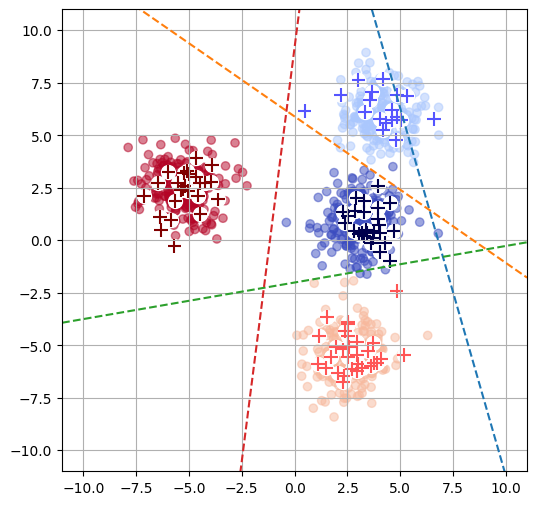

[[ 0.02518965  0.00184552 -0.01057837 -0.37612774]
 [ 0.00299566  0.01281711 -0.14524313  0.0395898 ]] [-0.04603268 -0.04362001 -0.10032694 -0.0718137 ]
SmoothedSurrogate 0.7511111111111111


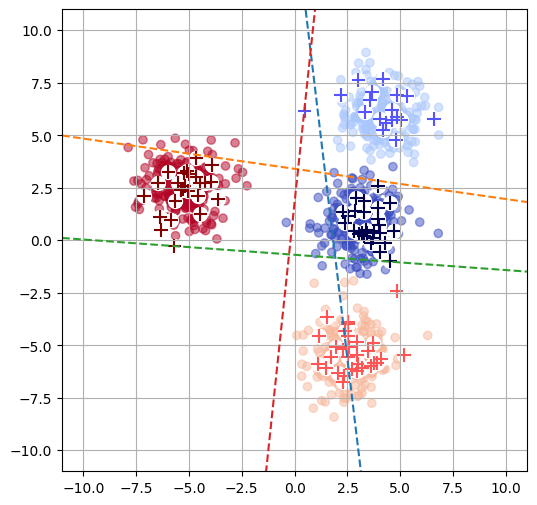

[[ 0.00926298  0.14769363 -0.08045946 -1.017631  ]
 [ 0.00215978  0.68741338 -1.32093081 -0.05527719]] [-1.01664408 -2.99500472 -1.80977101 -0.1839702 ]
HingeLoss 0.9555555555555556


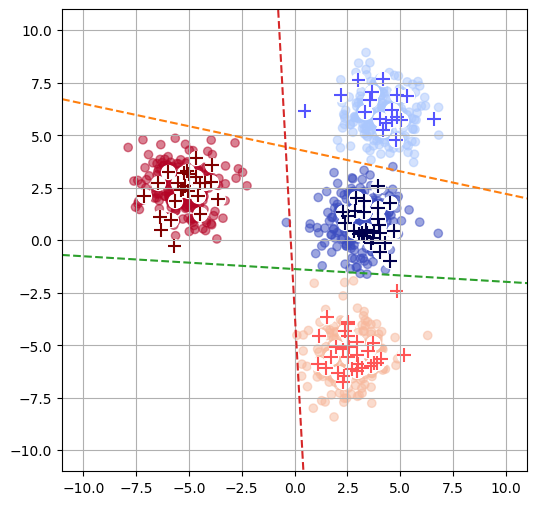

[[  13.82773946    3.6534862   -26.19423934 -248.79569176]
 [  -1.22836443   41.83170038 -191.82398345   27.01901432]] [-59.89156168 -94.45582642 -71.9801624  -73.54140156]
LogLikehood 0.91


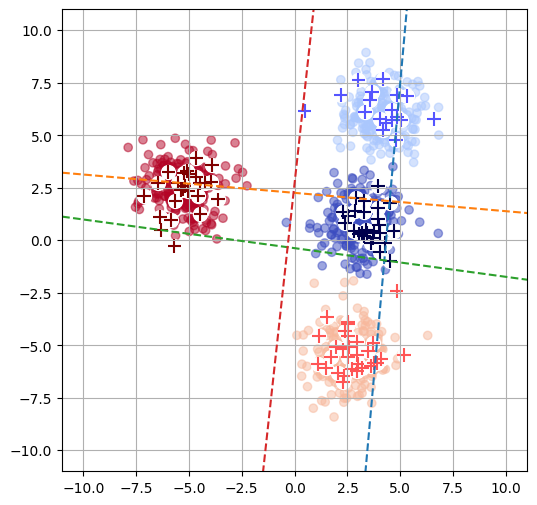

In [89]:
from sklearn.model_selection import train_test_split
cost_functions = [WidrowHoff, SmoothedSurrogate, HingeLoss, LogLikehood]

X, y = generate_multiclass_dataset(1000, 4)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

for cost in cost_functions:
  model = NeuralNetwork(algorithm=GradientDescent(10000, 0.0001, cost()))
  model.fit(X_train, y_train)
  print(model.coefs_, model.intercept_)
  ypred = model.predict(X_test)
  print(cost.__name__, accuracy_score(y_test, ypred))
  plot_dataset(X_test, y_test)
  plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c='white', s=100)
  plt.scatter(X_train[:, 0], X_train[:, 1], marker='+', c=y_train, cmap='seismic', s=100)
  for i in range(model.w.shape[1]):
    plot_hyperplane(model.coefs_[:, i], model.intercept_[i])
  plt.show()
